In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


# 베이스라인 

In [2]:
import pandas as pd
data_path = "/kaggle/input/bike-sharing-demand/"

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

## 피처 엔지니어링 

### 이상치 제거 

In [4]:
train = train[train['weather'] != 4] # 폭우내릴 때 대여 건수 1개 제거 

### 데이터 합치기 

In [5]:
all_day_temp = pd.concat([train, test])
all_day_temp

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [6]:
all_data = pd.concat([train, test], ignore_index = True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


### 파생변수 추가

In [7]:
from datetime import datetime

all_data['date'] = all_data['datetime'].apply(lambda x: x.split()[0])
all_data['year'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
all_data['month'] = all_data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
all_data['hour'] = all_data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
all_data['weekday'] = all_data['date'].apply(lambda dateString: datetime.strptime(dateString, "%Y-%m-%d").weekday())

### 필요없는 피처 제거

In [8]:
drop_features = ['casual', 'registered','datetime','date','month','windspeed']
all_data = all_data.drop(drop_features, axis = 1)

### 데이터 나누기

In [9]:
# 훈련 데이터와 테스트 데이터 나누기 
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거 
X_train = X_train.drop(['count'], axis = 1)
X_test = X_test.drop(['count'], axis = 1)

y = train['count']

In [10]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


## 평가지표 계산 함수 작성 

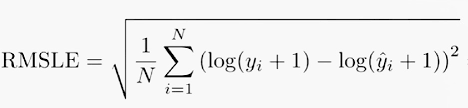

In [15]:
import numpy as np

def rmsle(y_true, y_pred, convertExp = True):
    if convertExp: # 지수변환
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    
    log_true = np.nan_to_num(np.log(y_true + 1))
    log_pred = np.nan_to_num(np.log(y_pred + 1))
    
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output 

## 모델 훈련 

선형 회귀란 종속 변수와 독립 변수의 선형 관계를 모델링하는 방법으로 실제값과 예측값의 차이를 최소화하는 선형 회귀식을 최적화하는 방법입니다. 

In [12]:
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()

In [13]:
log_y = np.log(y) # 타깃값을 로그 변환하여 정규분포에 가깝게 만듦
linear_reg_model.fit(X_train, log_y)

LinearRegression()

## 모델 성능 검증 

In [19]:
preds = linear_reg_model.predict(X_train)
print(f"선형회귀의 RMSLE 값 : {rmsle(log_y, preds, True)}")

선형회귀의 RMSLE 값 : 1.0204980189305008


## 예측 및 결과 제출

In [21]:
linearreg_preds = linear_reg_model.predict(X_test)

submission['count'] = np.exp(linearreg_preds)
submission.to_csv("submission.csv", index = False)